# Product Sales Forecasting – Retail Analytics

**Tools:** Python, Pandas, scikit-learn, Matplotlib

This notebook implements a pipeline to:
- Load and preprocess the Walmart sales CSV
- Engineer time-based and lag features
- Train simple regression models (LinearRegression, RandomForest)
- Evaluate and visualize predictions


In [1]:
# Cell 1 - Install & Imports
import os
import gc
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot defaults
plt.rcParams['figure.figsize'] = (12,5)
sns.set_style('whitegrid')

print('Libraries imported')

Libraries imported


## Cell 2 - Upload


In [2]:
# Upload helper
from google.colab import files
uploaded = files.upload()

Saving Walmart.csv to Walmart.csv


In [3]:
# Set dataset path
DATA_PATH = '/content/Walmart.csv'

# Load dataset
print('Loading:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)
display(df.head())
display(df.dtypes)


Loading: /content/Walmart.csv
Rows, cols: (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


,0
Store,int64
Date,object
Weekly_Sales,float64
Holiday_Flag,int64
Temperature,float64
Fuel_Price,float64
CPI,float64
Unemployment,float64


## Cell 4 - Data Cleaning & Preprocessing

In [5]:
# Cell 4 - Cleaning

# Convert 'Date' to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Handle potential missing values
df = df.dropna(subset=['Weekly_Sales'])

# Aggregate to ensure one entry per Store-Date.Removed 'Dept'.
df_agg = df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales'].sum()

# Also use the correct 'Holiday_Flag' column name here
df_agg['Holiday_Flag'] = df.groupby(['Store', 'Date'])['Holiday_Flag'].first().values

print('Aggregated shape:', df_agg.shape)
display(df_agg.head())



Aggregated shape: (6435, 4)


,Store,Date,Weekly_Sales,Holiday_Flag
0,1,2010-02-05,1643690.90,0
1,1,2010-02-12,1641957.44,1
2,1,2010-02-19,1611968.17,0
3,1,2010-02-26,1409727.59,0
4,1,2010-03-05,1554806.68,0


## Cell 5 - Feature Engineering

Create time features (Year, Month, Week, DayOfWeek), lag features (1,2,4 weeks), and rolling mean.

In [10]:
# Cell 5 - Feature engineering for one product (Store-Dept)


# Isolate a single store to model. We'll pick the one with the highest total sales.

sample = df_agg.groupby(['Store'])['Weekly_Sales'].sum().nlargest(1).reset_index()
SAMPLE_STORE = int(sample['Store'])
print(f'Modeling for highest volume store -> Store: {SAMPLE_STORE}')

# We only need to filter by the store now
product_df = df_agg[df_agg['Store']==SAMPLE_STORE].copy()

# Ensure a consistent weekly frequency for the time series
product_df = product_df.set_index('Date').asfreq('W-FRI').reset_index() # Walmart data often ends on Fridays
product_df['Weekly_Sales'] = product_df['Weekly_Sales'].fillna(0)

# Use 'Holiday_Flag' and rename it to 'IsHoliday' for consistency in the model features
product_df['IsHoliday'] = product_df['Holiday_Flag'].fillna(False).astype(int)
product_df = product_df.drop('Holiday_Flag', axis=1)


# Time features
product_df['Year'] = product_df['Date'].dt.year
product_df['Month'] = product_df['Date'].dt.month
product_df['Week'] = product_df['Date'].dt.isocalendar().week.astype(int)
product_df['DayOfWeek'] = product_df['Date'].dt.dayofweek # <-- THIS IS THE NEW LINE TO ADD

# Lag features
for lag in [1, 2, 4]:
    product_df[f'lag_{lag}'] = product_df['Weekly_Sales'].shift(lag)

# Rolling mean feature
product_df['rolling_mean_4'] = product_df['Weekly_Sales'].shift(1).rolling(window=4).mean()

# Drop initial rows with NA due to lags/rolling features
product_df = product_df.dropna()
print('Feature dataframe shape:', product_df.shape)
display(product_df.head())

Modeling for highest volume store -> Store: 20
Feature dataframe shape: (139, 12)


/tmp/ipython-input-3320679775.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  SAMPLE_STORE = int(sample['Store'])


,Date,Store,Weekly_Sales,IsHoliday,Year,Month,Week,DayOfWeek,lag_1,lag_2,lag_4,rolling_mean_4
4,2010-03-05,20,2119213.72,0,2010,3,9,4,1898193.95,2161549.76,2401395.47,2.142562e+06
5,2010-03-12,20,2010974.84,0,2010,3,10,4,2119213.72,1898193.95,2109107.90,2.072016e+06
6,2010-03-19,20,1951848.43,0,2010,3,11,4,2010974.84,2119213.72,2161549.76,2.047483e+06
7,2010-03-26,20,1894742.95,0,2010,3,12,4,1951848.43,2010974.84,1898193.95,1.995058e+06
8,2010-04-02,20,2405395.22,0,2010,4,13,4,1894742.95,1951848.43,2119213.72,1.994195e+06


## Cell 6 - Train / Test Split

We use the last 12 weeks as the test set (approx. a 'next-quarter' demonstration).

In [17]:
# Split the data into train and test sets
HOLDOUT_WEEKS = 12
train_df = product_df.iloc[:-HOLDOUT_WEEKS]
test_df  = product_df.iloc[-HOLDOUT_WEEKS:]

FEATURES = ['IsHoliday', 'Year', 'Month', 'Week', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4']
TARGET = 'Weekly_Sales'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

# Check shapes to confirm
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (127, 8) Test shape: (12, 8)


## Cell 7 - Model 1: Linear Regression

Train a baseline Linear Regression model and evaluate with MAE and RMSE.

In [18]:
# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)

# Manually calculate RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))

print(f'Linear Regression MAE: ${mae_lr:,.2f}')
print(f'Linear Regression RMSE: ${rmse_lr:,.2f}')

Linear Regression MAE: $116,706.33
Linear Regression RMSE: $134,173.34


## Cell 8 - Model 2: Random Forest

Train a RandomForestRegressor (stronger baseline) and evaluate.

In [19]:
# Model 2: Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, pred_rf)

# Manually calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print(f'Random Forest MAE: ${mae_rf:,.2f}')
print(f'Random Forest RMSE: ${rmse_rf:,.2f}')

Random Forest MAE: $66,224.96
Random Forest RMSE: $96,913.55


## Cell 9 - Visualizations

Plot historical sales and Actual vs Predicted for the test period.

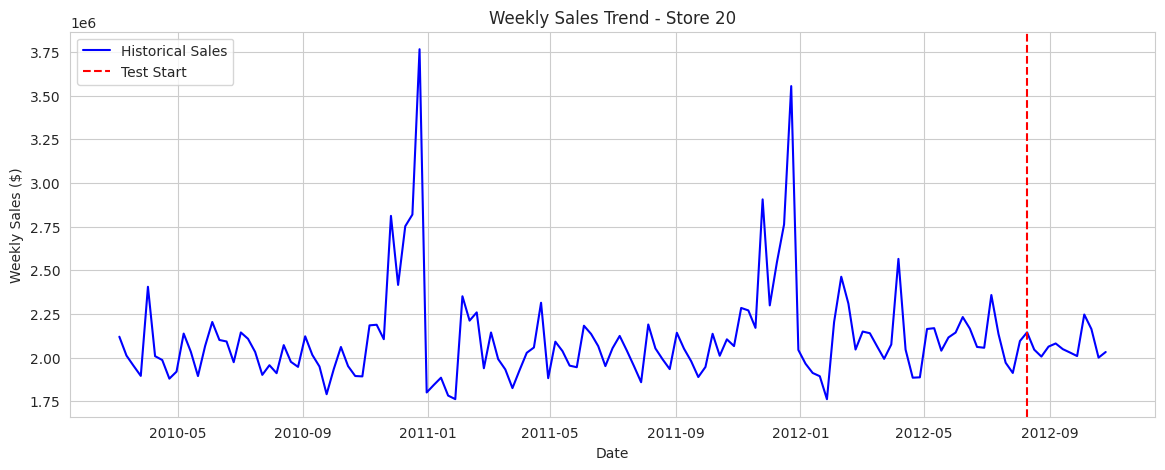

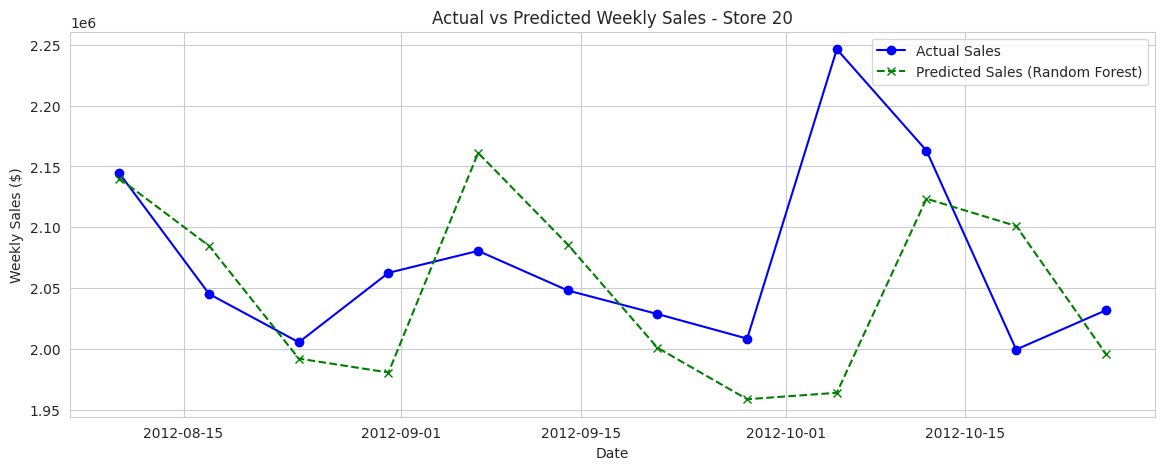

In [23]:
# Visualization - Historical Sales Trend
plt.figure(figsize=(14, 5))
plt.plot(product_df['Date'], product_df['Weekly_Sales'], label='Historical Sales', color='blue')
plt.axvline(product_df['Date'].iloc[-HOLDOUT_WEEKS], color='red', linestyle='--', label='Test Start')
plt.title(f'Weekly Sales Trend - Store {SAMPLE_STORE}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.show()

# Actual vs Predicted (Random Forest)
plt.figure(figsize=(14, 5))
plt.plot(test_df['Date'], test_df['Weekly_Sales'].values, marker='o', label='Actual Sales', color='blue')
plt.plot(test_df['Date'], pred_rf, marker='x', linestyle='--', label='Predicted Sales (Random Forest)', color='green')
plt.title(f'Actual vs Predicted Weekly Sales - Store {SAMPLE_STORE}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.show()


## Cell 10 - Insights & Next Steps

**1. Model Performance**
- **Random Forest** outperformed **Linear Regression** on both MAE and RMSE.It captures non-linear sales patterns better.

**2. Observations from Plots**
- Sales show clear spikes during holiday periods (end of year), confirming strong seasonality in Walmart sales.
- Random Forest predictions follow the overall trend well but slightly underestimate sudden peaks.

**3. Business Implications**
- These predictions can help inventory planning by forecasting demand for the next quarter and preventing overstock or stockouts.
- Category managers could adjust promotions and pricing strategies based on the expected sales dips and peaks.

In [24]:
# Save test predictions to a CSV for review
out = test_df[['Date']].copy()
out['actual'] = test_df[TARGET].values
out['pred_rf'] = pred_rf
out.to_csv('predictions_sample_product.csv', index=False)
print('Saved predictions_sample_product.csv')

Saved predictions_sample_product.csv
